In [198]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.distributions import Interpolated
from scipy import stats
import pandas as pd 
import os 
#import theano.tensor as tt
# Step 1: Import Data 
# Data in this order 
# Colums of data
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("mix_hb_tcr.csv", engine = 'python')


In [199]:
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)


def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5

    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma

    return floatX(tau), floatX(sigma)


class Sum_of_Squares(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()


In [200]:
df.head()

,Age,Age Error,40Ar_r,39Ar,37Ar,36Ar,Temperature (Degrees Celcius)
0,22.57,4.02,0.788082,0.088461,0.000423,0.005909,652.131965
1,25.81,3.15,2.836287,0.278071,0.000424,0.014531,748.318352
2,25.67,1.77,2.808423,0.276864,0.000425,0.007878,754.872661
3,25.51,1.10,2.656281,0.263567,0.000157,0.004292,761.325348
4,25.46,0.84,2.402813,0.238880,0.000158,0.002614,767.679517


In [201]:
# DATA
age = df['Age'].values
age_err = df['Age Error'].values
a40 = df['40Ar_r'].values
a39 = df['39Ar'].values
temp = df['Temperature (Degrees Celcius)'].values
time= 300*np.ones(len(temp))
data = age

In [202]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [203]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [204]:
def fracrel(a):
    y = np.cumsum(a)
    z = y/y.max()
    return z
data2 = fracrel(a39)

# Plotting Functions

In [205]:
import seaborn as sns
sns.set_style('ticks')
font = {"family": "Arial", 
      "size": 16, 
      "weight": "normal"}

plt.rc("font", **font)

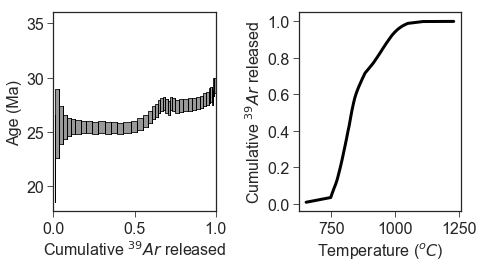

In [206]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize = (7,4))
ax[0].fill_between(data2, data - age_err, data + age_err, 
                  step = 'pre', facecolor = 'grey', alpha = 0.8, 
                  edgecolor = 'k')
ax[0].set_xlabel('Cumulative $^{39}Ar$ released')
ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlim(0, 1)


for i in range(len(data)): 
    ax[0].vlines(data2, data - age_err, data + age_err,
              color = 'k', lw = 0.5)

ax[1].plot(temp, data2, lw = 3, color= 'k')
ax[1].set_ylabel('Cumulative $^{39}Ar$ released')
ax[1].set_xlabel('Temperature ($^{o}C$)')
plt.tight_layout()

In [207]:
import theano 
from theano import shared, tensor as tt
data = age
tk = temp + 273.15
time 
N = data.shape[0]
err_age = shared(age_err*2)
t_obs = time

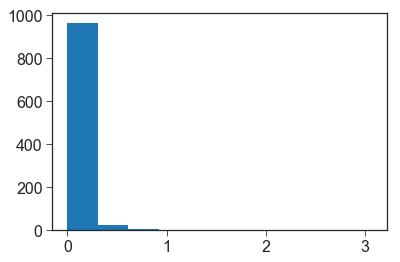

In [208]:
y = np.random.lognormal(-4,1.6, 1000)
plt.hist(y);

In [242]:
W = pm.Model() 

with W: 
    
    """ Mixing Fraction for each component """
    phi = pm.Dirichlet('phi', a = np.array([1,1]), 
                      shape = 2)

    p1 = phi[0]; p2 = phi[1]
    
    """
    Diffusion Kinetics
    Ea - Activation Energy (kJ/mol)
    D0 - Frequency Factor (ln(s^-1))
    """
    ea1 = pm.Normal('ea1', mu = 190, sd = 5)
    
    ea2 = pm.Normal('ea2', mu = 220, sd = 5)

    d01 = pm.Lognormal('d01', -4, 0.5)

    d02 = pm.Lognormal('d02', -3, 0.5)

    """ Effective Diffusion Lengthscale """

    a1 = pm.Uniform('a1',
                    lower = 0.001, 
                    upper = 0.0032)
    
    a2 = pm.Uniform('a2',
                    lower = 0.001, 
                    upper = 0.0032)



In [243]:
with W: 

    
    #age1 = pm.Uniform('age1', lower = 0.0, 
    #                upper = 4600)
    
    #age2= pm.Uniform('age2', lower = 0.0, 
    #                upper = 4600)
    
    age1 = pm.Normal('age1', mu = 24.5, sd = 0.5)
    
    age2 = pm.Normal('age2', mu = 28.5, sd = 0.5)
    

In [244]:
with W:
    # Mixture weights
    w1 = p1
    w2 = p2


    X = Increment(ea1, d01, a1, tk, time)
    Y = Increment(ea2, d02, a2, tk, time)
    
    YY = pm.Deterministic('YY', Y)
    XX = pm.Deterministic('XX', X)
    
    qq = w1*X + w2*Y
    mix1 = ((w1*X)/(qq))
    mix2 = ((w2*Y)/(qq))

In [245]:
with W:    
    #Fractional Release
    A = fracrelx(ea1, d01, a1, tk, time)
    B = fracrelx(ea2, d02, a2, tk, time)
    A = pm.Deterministic('A', A)
    B = pm.Deterministic('B', B)
    #Model
    mu1 = w1*A + w2*B
    
    #mu1 = mix1*A + mix2*B
 ############################################################################
    # Add Monontonic Constraints to all fractional release 
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_cons{i}', 
                                       tt.switch(A[i + 1] - A[i] < 0, 
                                                 -np.inf, 0) + 
                                       tt.switch(B[i + 1] - B[i] < 0, 
                                                -np.inf, 0)) 
        
    # Add Monontonic Constraints to all fractional release 
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_consbb{i}', 
                                       tt.switch(mu1[i + 1] - mu1[i] < 0, 
                                                 -np.inf, 0) + 
                                   tt.switch(mu1.max() > 1, -np.inf, 0))
###########################################################################
    # Model 
    model1 = pm.Deterministic('model1', mu1)
    # Fractional Release Equation 
    f_err1 = pm.HalfNormal('f_err1', sd = 0.05)
    
    

In [246]:
with W: 
    #Age Spectra Model
    mu2 = ((p1*X*age1)/(p1*X + p2*Y)) + ((p2*Y*age2)/(p1*X + p2*Y))
    
    age_err_model = pm.HalfNormal('age_err', sd = 1)

In [247]:
with W: 
    # Age Spectra Likelihood 
    obs1 = Sum_of_Squares('obs1', mu = mu2, 
                    sd = err_age, 
                    observed = data)
    
    # Cumulative Release Likelihood
    obs2 = pm.Normal('obs2', 
                    mu = mu1, 
                    sd = f_err1, 
                    observed = data2)
    

# Check Test Probabilities

In [248]:
W.check_test_point()

a1_interval__            -1.39
a2_interval__            -1.39
age1                     -0.23
age2                     -0.23
age_err_log__            -0.77
d01_log__                -0.92
d02_log__                -0.92
ea1                      -2.53
ea2                      -2.53
f_err1_log__             -0.77
obs1                    -27.98
obs2                  -2991.34
phi_stickbreaking__     -59.61
Name: Log-probability of test_point, dtype: float64

In [249]:
SEED = np.random.seed(123)
SAMPLES = 50000
BURN = 50000
with W: 
    step1 = pm.Metropolis([d01, d02, 
                          ea1, ea2, 
                          age_err_model, 
                          f_err1, 
                          age1, age2])
    
    
    step2 = pm.Metropolis([a1, a2, phi], 
                         scaling = 0.25)

    
    trace = pm.sample(SAMPLES, 
                      tune = BURN,  
                      step = [step1, 
                             step2],  
                     random_seed = SEED, 
                     cores = 1, 
                     chains = 1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [age2]
>>Metropolis: [age1]
>>Metropolis: [f_err1]
>>Metropolis: [age_err]
>>Metropolis: [ea2]
>>Metropolis: [ea1]
>>Metropolis: [d02]
>>Metropolis: [d01]
>CompoundStep
>>Metropolis: [phi]
>>Metropolis: [a2]
>>Metropolis: [a1]
100%|██████████| 100000/100000 [17:56<00:00, 92.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


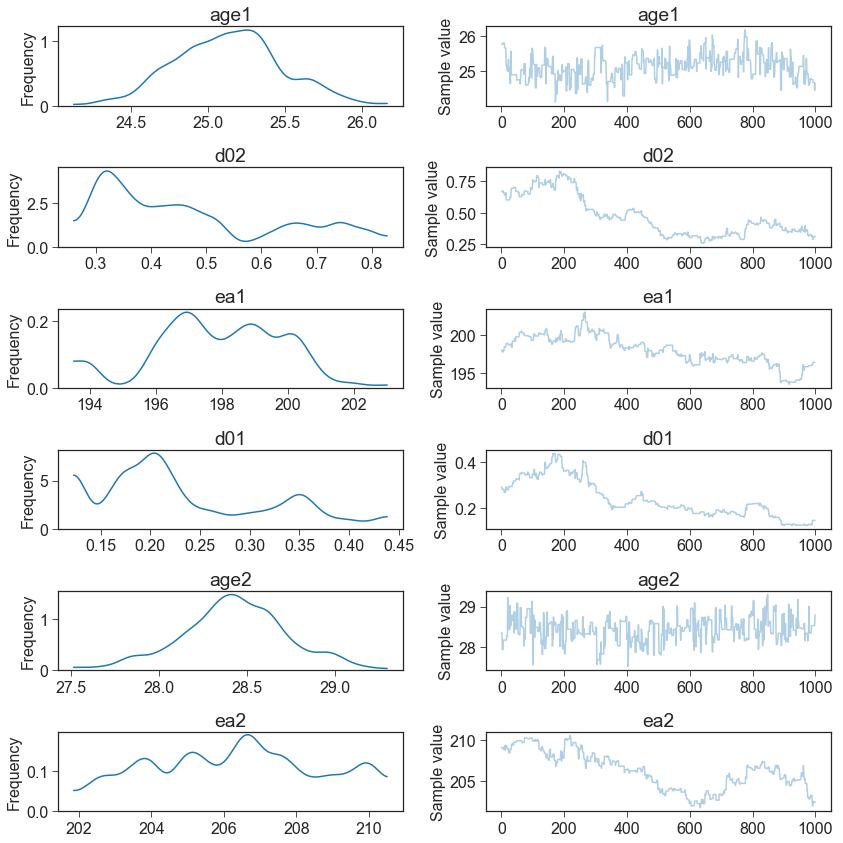

In [250]:
sns.set_style('ticks')
pm.traceplot(trace[-1000:], 
            varnames = {'ea1', 'ea2', 
                  'd01', 'd02', 
                  'age1', 'age2'}); 

In [251]:
print(trace['age1'][-1000:].mean(axis = 0), trace['age2'][-1000:].mean(axis = 0))
print(trace['age1'][-1000:].std(axis = 0), trace['age2'][-1000:].std(axis = 0))

25.13229040354676 28.427326098081338
0.3412673042689973 0.29906809857820643


In [252]:
with W: 
    ppc = pm.sample_ppc(trace, 5000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 5000/5000 [00:46<00:00, 108.41it/s]


In [253]:
f_low, f_high = np.percentile(ppc['obs2'][-2000:],
                              [2.5, 97.5],
                              axis = 0)

age_mod_low, age_mod_high = np.percentile(ppc['obs1'][-2000:], 
                                         [2.5, 97.5], 
                                         axis = 0)

zz1 = ppc['obs2'].mean(axis = 0)
zz2 = ppc['obs1'].mean(axis = 0)

In [254]:
# Plotting Parameters

age_low_plot = np.insert(age_mod_low, 0, age_mod_low[0])
age_high_plot = np.insert(age_mod_high, 0, age_mod_high[0])
f_mod_plot = np.insert(zz1, 0, 0)

model_plot = np.insert(zz2, 0, zz2[0])

data_err_plot = np.insert(age_err, 0, age_err[0])
data_plot = np.insert(age, 0, age[0])
f_plot = np.insert(data2, 0, 0)



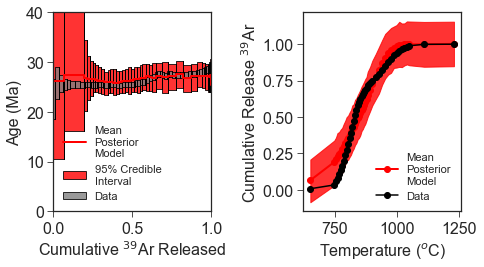

In [255]:
fig, ax = plt.subplots(1, 2, figsize = (7, 4))
ww = data2
ax[0].fill_between(f_mod_plot, age_low_plot, 
                  age_high_plot, 
                  step = 'pre',  
                  alpha = 0.8, 
                  facecolor = 'r', 
                  label = '95% Credible\nInterval', 
                  edgecolor = 'k')

ax[0].plot(f_mod_plot, model_plot, 'r-', 
          lw = 2, 
          label = 'Mean\nPosterior\nModel', 
          drawstyle = 'steps')


ax[0].fill_between(f_plot, data_plot + data_err_plot,
                   data_plot - data_err_plot, 
        step = 'pre', alpha = 0.8, facecolor = 'grey',
          edgecolor = 'k', 
                  label = 'Data')

for i in range(len(data)): 
    ax[0].vlines(f_mod_plot, age_low_plot, 
                  age_high_plot, color = 'k', lw= 0.7)

for i in range(len(data)): 
    ax[0].vlines(f_plot, data_plot + data_err_plot,
                   data_plot - data_err_plot,  color = 'k', lw= 0.7)

ax[1].fill_between(temp, f_low, f_high, 
                  color = 'r', alpha = 0.8)

ax[1].plot(temp, zz1, '-or', 
          lw = 2, label = 'Mean\nPosterior\nModel')
ax[1].plot(temp, ww, '-ok', 
          label = 'Data')

ax[0].set_ylim(0, 40)
ax[0].set_xlim(0, 1)


ax[0].set_xlabel('Cumulative $^{39}$Ar Released')
ax[0].set_ylabel('Age (Ma)')

ax[1].set_xlabel('Temperature ($^{o}$C)')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[0].legend(fontsize = 'x-small')
ax[1].legend(fontsize = 'x-small')
plt.tight_layout()

# DataFrame for PairGrid


In [262]:
dfx = pm.trace_to_dataframe(trace[-50000::5])

In [263]:
df_pairgrid = pd.DataFrame({"age1":dfx['age1'].values, 
                   "age2": dfx['age2'].values, 
                   "ea1":dfx['ea1'].values, 
                   "ea2":dfx['ea2'].values, 
                   "d01":dfx['d01'].values, 
                   "d02":dfx['d02'].values})


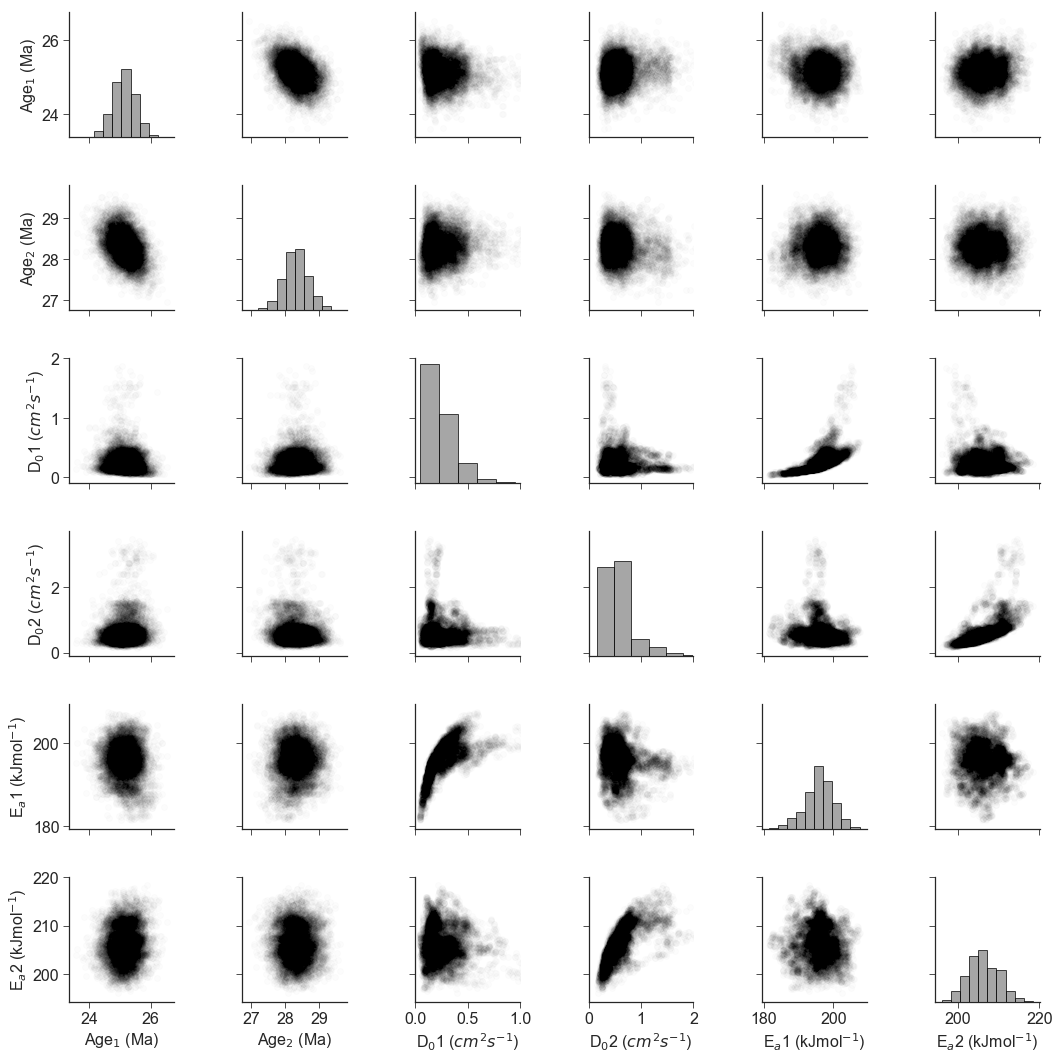

In [266]:
import seaborn as sns
g = sns.PairGrid(df_pairgrid)
g = g.map_diag(plt.hist, facecolor = 'grey', edgecolor = 'k', 
              alpha = 0.7)
g = g.map_offdiag(plt.scatter, alpha = 0.01, color = 'k')


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[3,0].set_ylabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('E$_a$1 (kJmol$^{-1}$)')
g.axes[5,0].set_ylabel('E$_a$2 (kJmol$^{-1}$)')



# X_AXIS LABELS

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[5,3].set_xlabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[5,4].set_xlabel('E$_a$1 (kJmol$^{-1}$)')
g.axes[5,5].set_xlabel('E$_a$2 (kJmol$^{-1}$)')

g.axes[5,2].set_xlim(0,1)
g.axes[5,3].set_xlim(0,2)
plt.tight_layout()